<a href="https://colab.research.google.com/github/MohsinAlam07/Decision-Tree-DT-Implementation/blob/main/210131_Decision%20Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)


In [3]:
url = "https://raw.githubusercontent.com/MohsinAlam07/Decision-Tree-DT-Implementation/main/tobacco.csv"
df = pd.read_csv(url)

df.head()

,id,kode_provinsi,nama_provinsi,kode_kabupaten_kota,nama_kabupaten_kota,jumlah_produksi,satuan,tahun
0,1,32,JAWA BARAT,3201,KABUPATEN BOGOR,0,TON,2016
1,2,32,JAWA BARAT,3202,KABUPATEN SUKABUMI,0,TON,2016
2,3,32,JAWA BARAT,3203,KABUPATEN CIANJUR,46,TON,2016
3,4,32,JAWA BARAT,3204,KABUPATEN BANDUNG,1358,TON,2016
4,5,32,JAWA BARAT,3205,KABUPATEN GARUT,3597,TON,2016


In [4]:
median_prod = df['jumlah_produksi'].median()

df['production_class'] = df['jumlah_produksi'].apply(
    lambda x: 1 if x > median_prod else 0
)


In [5]:
df.drop('id', axis=1, inplace=True)


In [6]:
categorical_cols = ['nama_provinsi', 'nama_kabupaten_kota', 'satuan']

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


In [7]:
X = df.drop(['jumlah_produksi', 'production_class'], axis=1)
y = df['production_class']


In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)


In [9]:
cart = DecisionTreeClassifier(criterion='gini', random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10]
}

cart_grid = GridSearchCV(
    cart,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

cart_grid.fit(X_train, y_train)

best_cart = cart_grid.best_estimator_


In [10]:
id3 = DecisionTreeClassifier(criterion='entropy', random_state=42)

id3_grid = GridSearchCV(
    id3,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

id3_grid.fit(X_train, y_train)

best_id3 = id3_grid.best_estimator_


In [11]:
models = {
    "CART (Gini)": best_cart,
    "ID3 (Entropy)": best_id3
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results[name] = {
        "y_pred": y_pred,
        "y_prob": y_prob,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob)
    }


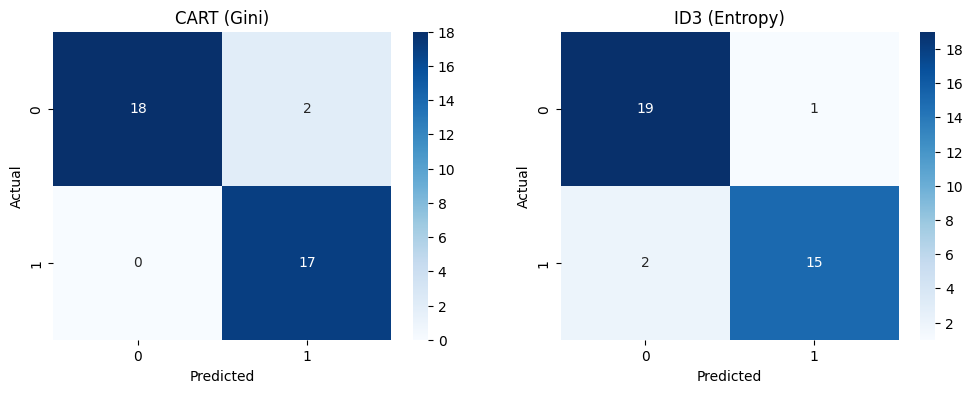

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

for ax, (name, res) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.show()


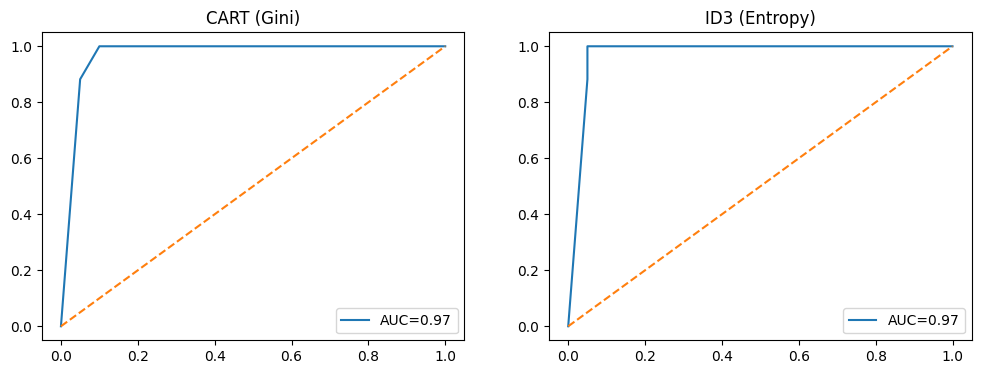

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

for ax, (name, res) in zip(axes, results.items()):
    fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
    ax.plot(fpr, tpr, label=f"AUC={res['AUC']:.2f}")
    ax.plot([0,1], [0,1], '--')
    ax.set_title(name)
    ax.legend()

plt.show()


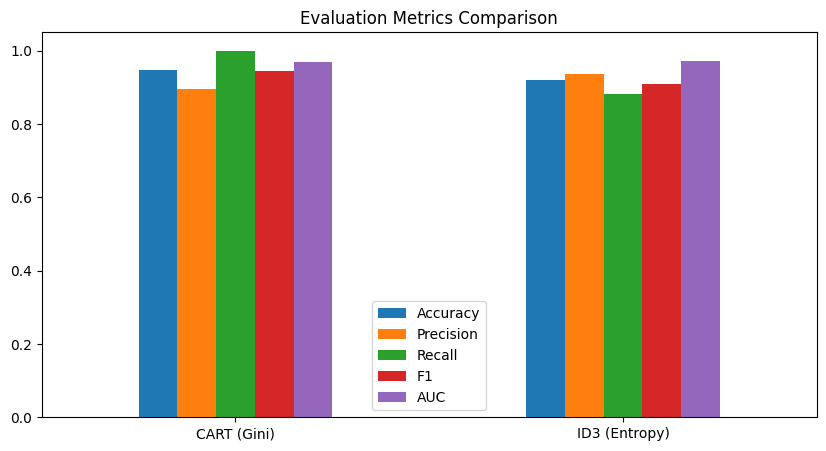

In [14]:
metrics_df = pd.DataFrame(results).T[
    ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
]

metrics_df.plot(kind='bar', figsize=(10,5))
plt.title("Evaluation Metrics Comparison")
plt.xticks(rotation=0)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


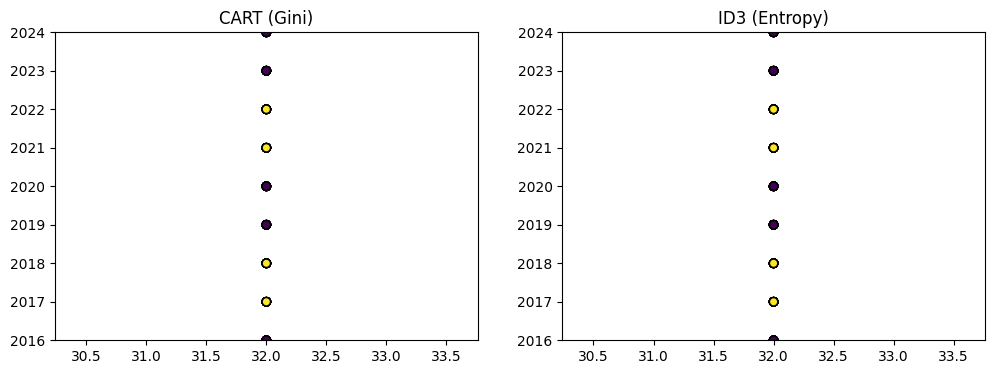

In [15]:
from matplotlib.colors import ListedColormap

X_2d = X[['kode_provinsi', 'tahun']]
y_2d = y

X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(
    X_2d, y_2d, test_size=0.2, random_state=42
)

fig, axes = plt.subplots(1, 2, figsize=(12,4))

for ax, (name, model) in zip(axes, models.items()):
    model.fit(X_train_2d, y_train_2d)

    xx, yy = np.meshgrid(
        np.linspace(X_train_2d.iloc[:,0].min(), X_train_2d.iloc[:,0].max(), 200),
        np.linspace(X_train_2d.iloc[:,1].min(), X_train_2d.iloc[:,1].max(), 200)
    )

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(['red','green']))
    ax.scatter(X_train_2d.iloc[:,0], X_train_2d.iloc[:,1], c=y_train_2d, edgecolor='k')
    ax.set_title(name)

plt.show()


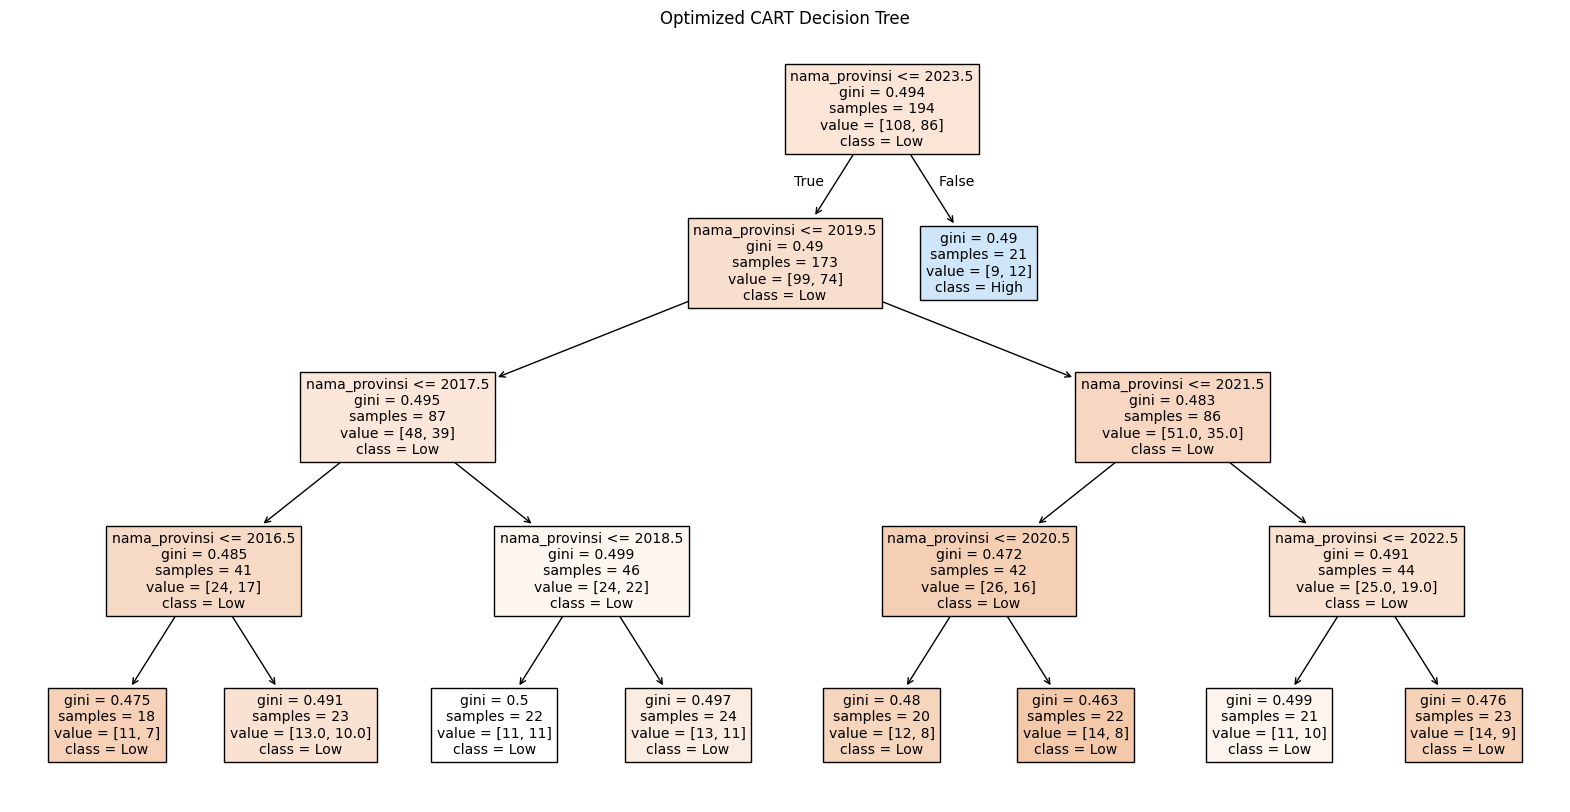

In [16]:
plt.figure(figsize=(20,10))
plot_tree(
    best_cart,
    feature_names=X.columns,
    class_names=['Low', 'High'],
    filled=True
)
plt.title("Optimized CART Decision Tree")
plt.show()
